# Ingest data from data source to S3 bucket

***

## Libraries

In [48]:
import sagemaker
import boto3
from datetime import datetime
from io import StringIO
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


## Variables

In [49]:
sess = sagemaker.Session() #Intialzie session

bucket = sess.default_bucket()
RD_Bucket = 'sdpd-bucket2' #Raw Data
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3 = boto3.client('s3') # Create an S3 client
s3_resource = boto3.resource('s3') # Create an S3 resource

print('Bucket - > ',bucket)
print('Role - > ',role)
print('Region - > ',region)
print('S3 - > ',s3)
print('S3 Resource - > ',s3_resource)

Bucket - >  sagemaker-us-east-1-690585323461
Role - >  arn:aws:iam::690585323461:role/LabRole
Region - >  us-east-1
S3 - >  <botocore.client.S3 object at 0x7f1504f9e4d0>
S3 Resource - >  s3.ServiceResource()


## Prepare landing zone

In [50]:
# Function to verify if bucket exist, if not create
def verify_create_bucket(bucket_name):
    response = s3.list_buckets()
    for bucket in response['Buckets']:
        if bucket['Name'] == bucket_name:
            print(f"The {bucket_name} bucket exists.")
            break
    else:
        print(f"The {bucket_name} bucket does not exist, creating")
        !aws s3 mb s3://{RD_Bucket}/

In [51]:
verify_create_bucket(RD_Bucket)

The sdpd-bucket2 bucket exists.


## Download Files

***

### Load calls

In [52]:
#function to download yearly data
def Get_Data(year):
    url = f"https://seshat.datasd.org/pd/pd_calls_for_service_{year}_datasd.csv"
    df = pd.read_csv(url)
    return df

In [53]:
# List of years since 2018
Years = list(range(2018,datetime.now().year+1))
Years

[2018, 2019, 2020, 2021, 2022, 2023]

In [54]:
sdpd_calls = pd.DataFrame()
#iterate over years
for year in tqdm(Years):
    year_df = Get_Data(year)
    year_df['Year'] = year
    sdpd_calls = pd.concat((sdpd_calls, year_df))

100%|██████████| 6/6 [00:20<00:00,  3.38s/it]


In [55]:
#Verify Shape
sdpd_calls.shape

(2920722, 15)

In [56]:
sdpd_calls = sdpd_calls.drop(['address_dir_intersecting', 'address_sfx_intersecting'], axis=1)

***

In [57]:
type_url = f"http://seshat.datasd.org/pd/pd_cfs_calltypes_datasd.csv"
dipo_url = f"http://seshat.datasd.org/pd/pd_dispo_codes_datasd.csv"
ripa_stops_url = "https://seshat.datasd.org/pd/ripa_stops_datasd.csv"
ripa_stops_dic = "https://seshat.datasd.org/pd/ripa_stops_dictionary_datasd.csv"

In [58]:
def download_file(url):
    df = pd.read_csv(url, low_memory=False)
    return df

In [59]:
type_df = download_file(type_url)
dispo_df = download_file(dipo_url)
ripa_stops_df = download_file(ripa_stops_url)
ripa_stops_dic_df = download_file(ripa_stops_dic)


***

## Save Date to Buckets

In [60]:
def move_2_bucket(bucket,subfolder_name,file_name,df):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3_resource.Object(bucket,
                       subfolder_name + file_name).put(Body=csv_buffer.getvalue())
    print(file_name,'loaded in',bucket,'bucket')
    

In [61]:
move_2_bucket(RD_Bucket,'Call_Data/','SDPD_Calls.csv',sdpd_calls)
move_2_bucket(RD_Bucket,'Type_Data/','SDPD_Type.csv',type_df)
move_2_bucket(RD_Bucket,'Dispo_Data/','SDPD_Dispo.csv',dispo_df)
move_2_bucket(RD_Bucket,'Stops_Data/','SDPD_Stops.csv',ripa_stops_df)
move_2_bucket(RD_Bucket,'Stops_Dic_Data/','SDPD_Stops_Dic.csv',ripa_stops_dic_df)

SDPD_Calls.csv loaded in sdpd-bucket2 bucket
SDPD_Type.csv loaded in sdpd-bucket2 bucket
SDPD_Dispo.csv loaded in sdpd-bucket2 bucket
SDPD_Stops.csv loaded in sdpd-bucket2 bucket
SDPD_Stops_Dic.csv loaded in sdpd-bucket2 bucket


<div class="alert alert-block alert-success">
<b>Data:</b> Loaded in S3 Buckets
</div>

***

## Aggregate Police Activity by Hour

### Functions

In [62]:
def events_hour(df,freq,date_field,groupby):
    df[date_field]=pd.to_datetime(df[date_field])
    df_group = df.groupby([
        pd.Grouper(key=date_field,freq=freq),
        groupby
    ]).size().reset_index(name='count')
    
    return df_group

In [63]:
def events_timeseries(df,freq,date_field):
    df[date_field]=pd.to_datetime(df[date_field], utc=True)
    df_group = df.groupby([
        pd.Grouper(key=date_field,freq=freq)
    ]).size().reset_index(name='count')
    
    return df_group

In [64]:
def categorise(row):  
    if row['count'] > 0 and row['count'] <= 130000:
        return 'Low Quarter'
    elif row['count'] > 150000:
        return 'High Quarter'
    return 'Normal Quarter'

### Datasets

In [65]:
time_series_priority = events_hour(sdpd_calls,'H','date_time','priority')
time_series = events_timeseries(sdpd_calls,'M','date_time')
time_series_hr = events_timeseries(sdpd_calls,'H','date_time')
time_series_q = events_timeseries(sdpd_calls,'Q','date_time')

In [66]:
#Priority
time_series_priority['year'] = time_series_priority['date_time'].dt.year
time_series_prior_2023 = time_series_priority[time_series_priority.year == 2023]


#Monthly
time_series['year'] = time_series['date_time'].dt.year
time_series['month'] = time_series['date_time'].dt.month_name()
time_series_complete = time_series[time_series.year != 2023]

#Quarter
time_series_q['year'] = time_series_q['date_time'].dt.year
time_series_q['quarter'] = pd.PeriodIndex(time_series_q.date_time, freq='Q')
time_series_q['Quarter'] = pd.PeriodIndex(time_series_q['quarter'], freq='Q').strftime('%Y-%m')
time_series_q['Level'] = time_series_q.apply(lambda row: categorise(row), axis=1)
time_series_complete_q = time_series_q[time_series_q.year != 2023]

#Hourly
time_series_hr['year'] = time_series_hr['date_time'].dt.year
time_series_hr['hour'] = time_series_hr['date_time'].dt.hour
#time_series_hr = time_series_hr[time_series_hr.year != 2023]
time_series_hr_grby =time_series_hr.groupby(by=["hour","year"]).mean()



In [67]:
time_series_hr_grby = time_series_hr_grby.rename_axis(['hour', 'year']).reset_index()

In [68]:
time_series_hr_grby['hour'] = time_series_hr_grby['hour'].astype(str)

***

# Data Preparation - Police Stop Data

In [69]:
ripa_stops_df.head()
#ripa_stops_df.dtypes

,stop_id,ori,agency,exp_years,date_stop,time_stop,stopduration,stop_in_response_to_cfs,officer_assignment_key,assignment,...,beat_name,pid,isstudent,perceived_limited_english,perceived_age,perceived_gender,gender_nonconforming,gend,gend_nc,perceived_lgbt
0,10000,CA0371100,SD,26,2018-07-15,19:31:37,5,0,1,"Patrol, traffic enforcement, field operations",...,Kearney Mesa 313,1,0,0,50,Male,0,1,NaN,No
1,100000,CA0371100,SD,1,2019-02-03,09:00:47,10,1,1,"Patrol, traffic enforcement, field operations",...,Hillcrest 627,1,0,0,35,Male,0,1,NaN,No
2,100000,CA0371100,SD,1,2019-02-03,09:00:47,10,1,1,"Patrol, traffic enforcement, field operations",...,Hillcrest 627,2,0,0,35,Male,0,1,NaN,No
3,100001,CA0371100,SD,2,2019-02-03,08:02:21,40,1,1,"Patrol, traffic enforcement, field operations",...,Chollas Creek 827,1,0,0,60,Male,0,1,NaN,No
4,100002,CA0371100,SD,1,2019-02-03,09:03:05,10,0,1,"Patrol, traffic enforcement, field operations",...,Pacific Beach 122,1,0,0,25,Female,0,2,NaN,No


## Data Cleansing: Duplicates, Outliers, Missing Data

In [70]:
# drop duplicates
ripa_stops_df_cleaned = ripa_stops_df.drop_duplicates()



In [71]:
# removing outliers

thres = 3
positions = []
columns = ['exp_years','stopduration', 'stop_in_response_to_cfs', 'perceived_age']

for i in columns:
    z_score = np.abs(stats.zscore(ripa_stops_df[i]))
    positions = np.where(z_score > 3)

ripa_stops_df_cleaned = ripa_stops_df.drop(ripa_stops_df.index[positions])



In [72]:
# handling missing data

print(ripa_stops_df_cleaned.isna().sum())

# drops unnecessary columns with excessive missing values 
ripa_stops_df_cleaned = ripa_stops_df_cleaned.drop(['intersection', 'address_block', 'land_mark', 'address_street', 'highway_exit', 'school_name', 'gend_nc'], axis=1)

# drops rows with na values in columns 
ripa_stops_df_cleaned = ripa_stops_df_cleaned.dropna(axis=0)

print("Verify Cleaned Columns")
print(ripa_stops_df_cleaned.isna().sum())

stop_id                           0
ori                               0
agency                            0
exp_years                         0
date_stop                         0
time_stop                         0
stopduration                      0
stop_in_response_to_cfs           0
officer_assignment_key            0
assignment                        0
intersection                 582548
address_block                 73169
land_mark                    651001
address_street                28001
highway_exit                 645488
isschool                          0
school_name                  650598
address_city                      1
beat                              1
beat_name                         1
pid                               0
isstudent                         0
perceived_limited_english         0
perceived_age                     0
perceived_gender                195
gender_nonconforming              0
gend                              0
gend_nc                     

## Feature Selection

In [73]:

# drops irrelevant columns

ripa_stops_df_cleaned = ripa_stops_df_cleaned.drop(['ori', 'agency', 'address_city', 'officer_assignment_key', 'assignment', 'perceived_limited_english', 'gender_nonconforming', 'gend', 'isschool', 'isstudent', 'perceived_lgbt'], axis=1)

print("Verify Dropped Columns")
print(ripa_stops_df_cleaned.dtypes)


Verify Dropped Columns
stop_id                      int64
exp_years                    int64
date_stop                   object
time_stop                   object
stopduration                 int64
stop_in_response_to_cfs      int64
beat                       float64
beat_name                   object
pid                          int64
perceived_age                int64
perceived_gender            object
dtype: object


## Feature Creation

In [74]:
ripa_stops_df['date_time'] = pd.to_datetime(ripa_stops_df['date_stop'] + ' ' + ripa_stops_df['time_stop'], utc=True)

## Feature Transformation

In [75]:

# convert categorical to numeric
print(ripa_stops_df_cleaned['perceived_gender'])

ripa_stops_df_cleaned['perceived_gender'].replace(['Male', 'Female'], [1,0], inplace = True)

print("Verify Conversion")
print(ripa_stops_df_cleaned['perceived_gender'])


0           Male
1           Male
2           Male
3           Male
4         Female
           ...  
653596      Male
653597      Male
653598      Male
653599    Female
653600      Male
Name: perceived_gender, Length: 650870, dtype: object
Verify Conversion
0         1
1         1
2         1
3         1
4         0
         ..
653596    1
653597    1
653598    1
653599    0
653600    1
Name: perceived_gender, Length: 650870, dtype: object


In [94]:
%store ripa_stops_df_cleaned

Stored 'ripa_stops_df_cleaned' (DataFrame)


In [76]:
ripa_stops_hr = events_timeseries(ripa_stops_df,'H','date_time')
ripa_stops_q = events_timeseries(ripa_stops_df,'Q','date_time')
ripa_stops_m = events_timeseries(ripa_stops_df,'M','date_time')

#Quarter
ripa_stops_q['year'] = ripa_stops_q['date_time'].dt.year
ripa_stops_q['quarter'] = pd.PeriodIndex(ripa_stops_q.date_time, freq='Q')
ripa_stops_q['Quarter'] = pd.PeriodIndex(ripa_stops_q['quarter'], freq='Q').strftime('%Y-%m')

#Monthly
ripa_stops_m['year'] = ripa_stops_m['date_time'].dt.year
ripa_stops_m['month'] = ripa_stops_m['date_time'].dt.month_name()
ripa_stops_m = ripa_stops_m[ripa_stops_m.year != 2023]
# = ripa_stops_m[ripa_stops_m.year != 2023]


#Hourly
ripa_stops_hr['year'] = ripa_stops_hr['date_time'].dt.year
ripa_stops_hr['hour'] = ripa_stops_hr['date_time'].dt.hour
#time_series_hr = time_series_hr[time_series_hr.year != 2023]
ripa_stops_hr_grby = ripa_stops_hr.groupby(by=["hour","year"]).mean()



In [77]:
ripa_stops_m.head()

,date_time,count,year,month
0,2018-07-31 00:00:00+00:00,17091,2018,July
1,2018-08-31 00:00:00+00:00,16420,2018,August
2,2018-09-30 00:00:00+00:00,14004,2018,September
3,2018-10-31 00:00:00+00:00,14548,2018,October
4,2018-11-30 00:00:00+00:00,13890,2018,November


# Police Stop Monthly Time Series 

In [78]:
print(ripa_stops_m.head())
print(ripa_stops_m.dtypes)

                  date_time  count  year      month
0 2018-07-31 00:00:00+00:00  17091  2018       July
1 2018-08-31 00:00:00+00:00  16420  2018     August
2 2018-09-30 00:00:00+00:00  14004  2018  September
3 2018-10-31 00:00:00+00:00  14548  2018    October
4 2018-11-30 00:00:00+00:00  13890  2018   November
date_time    datetime64[ns, UTC]
count                      int64
year                       int64
month                     object
dtype: object


In [93]:
%store ripa_stops_m

Stored 'ripa_stops_m' (DataFrame)


In [79]:
ripa_stops_m.set_index('date_time', inplace = True)
ripa_stops_ts = ripa_stops_m['count']
ripa_stops_ts.head(10)
#print(ripa_stops_ts.dtypes)


date_time
2018-07-31 00:00:00+00:00    17091
2018-08-31 00:00:00+00:00    16420
2018-09-30 00:00:00+00:00    14004
2018-10-31 00:00:00+00:00    14548
2018-11-30 00:00:00+00:00    13890
2018-12-31 00:00:00+00:00    13532
2019-01-31 00:00:00+00:00    14533
2019-02-28 00:00:00+00:00    12565
2019-03-31 00:00:00+00:00    16209
2019-04-30 00:00:00+00:00    15733
Name: count, dtype: int64

In [92]:
%store ripa_stops_ts 

Stored 'ripa_stops_ts' (Series)


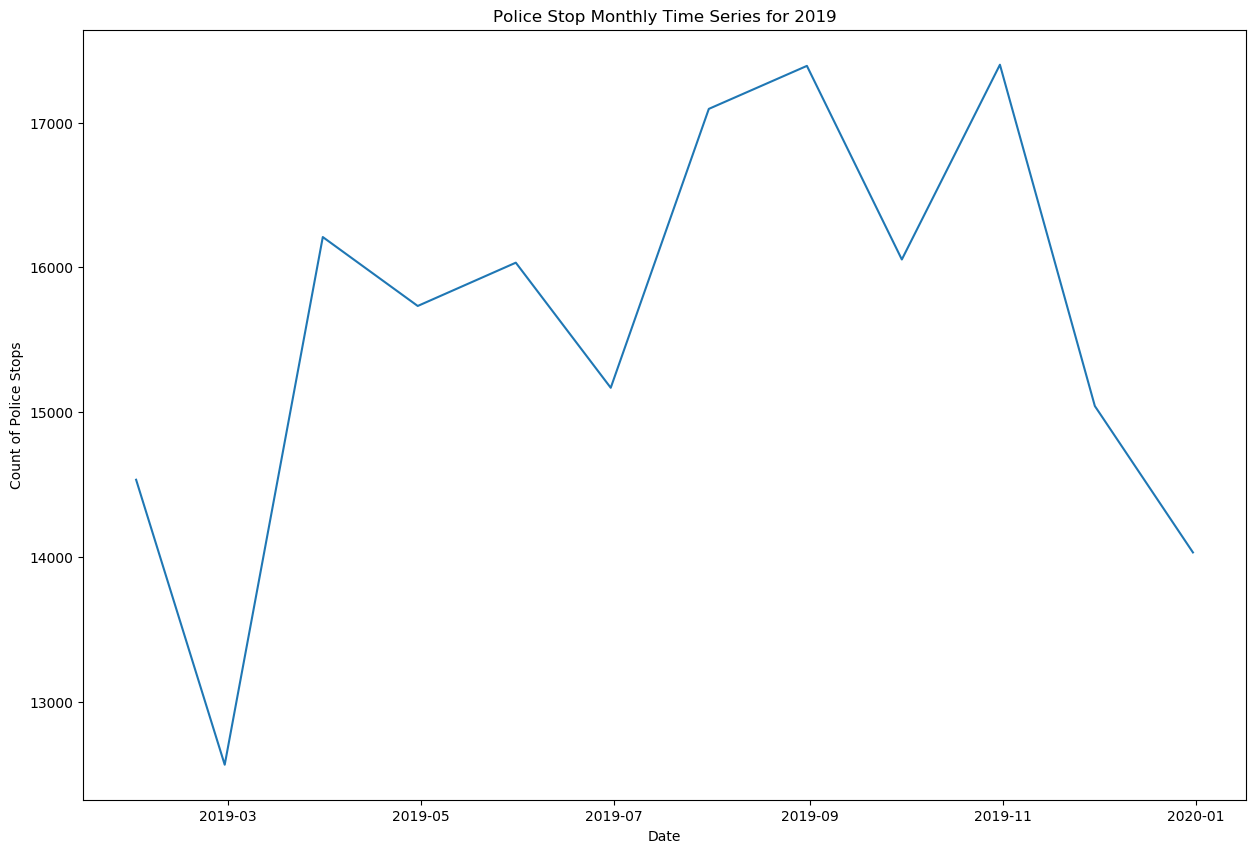

In [80]:

plt.plot(ripa_stops_ts['2019'])
plt.title("Police Stop Monthly Time Series for 2019")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.show()

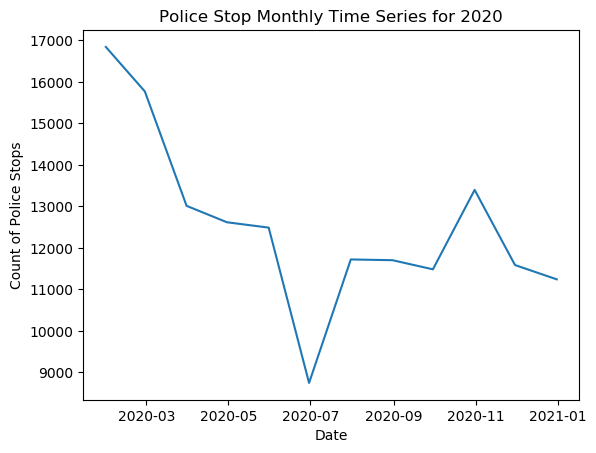

In [81]:
plt.plot(ripa_stops_ts['2020'])
plt.title("Police Stop Monthly Time Series for 2020")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.show()

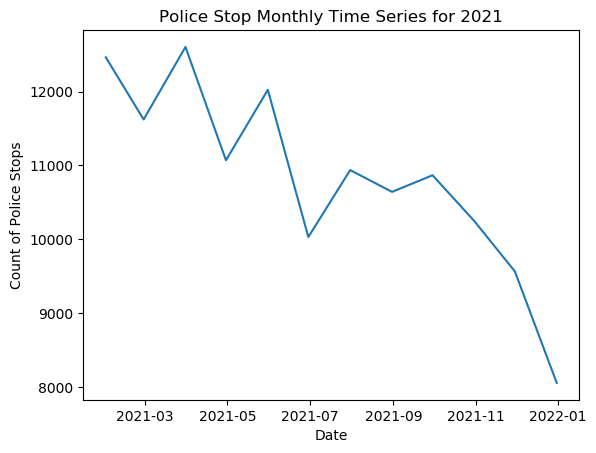

In [82]:
plt.plot(ripa_stops_ts['2021'])
plt.title("Police Stop Monthly Time Series for 2021")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.show()

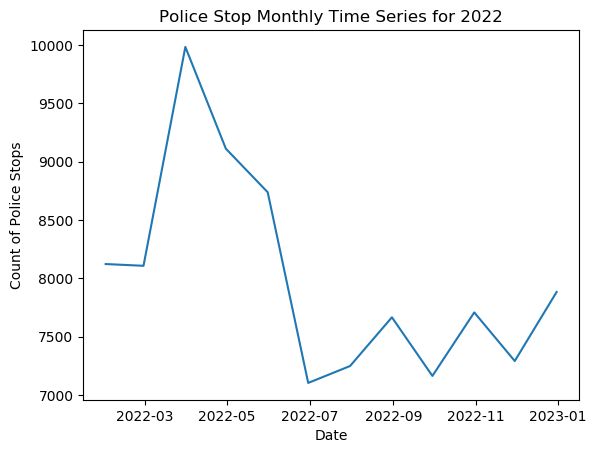

In [83]:
plt.plot(ripa_stops_ts['2022'])
plt.title("Police Stop Monthly Time Series for 2022")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.show()

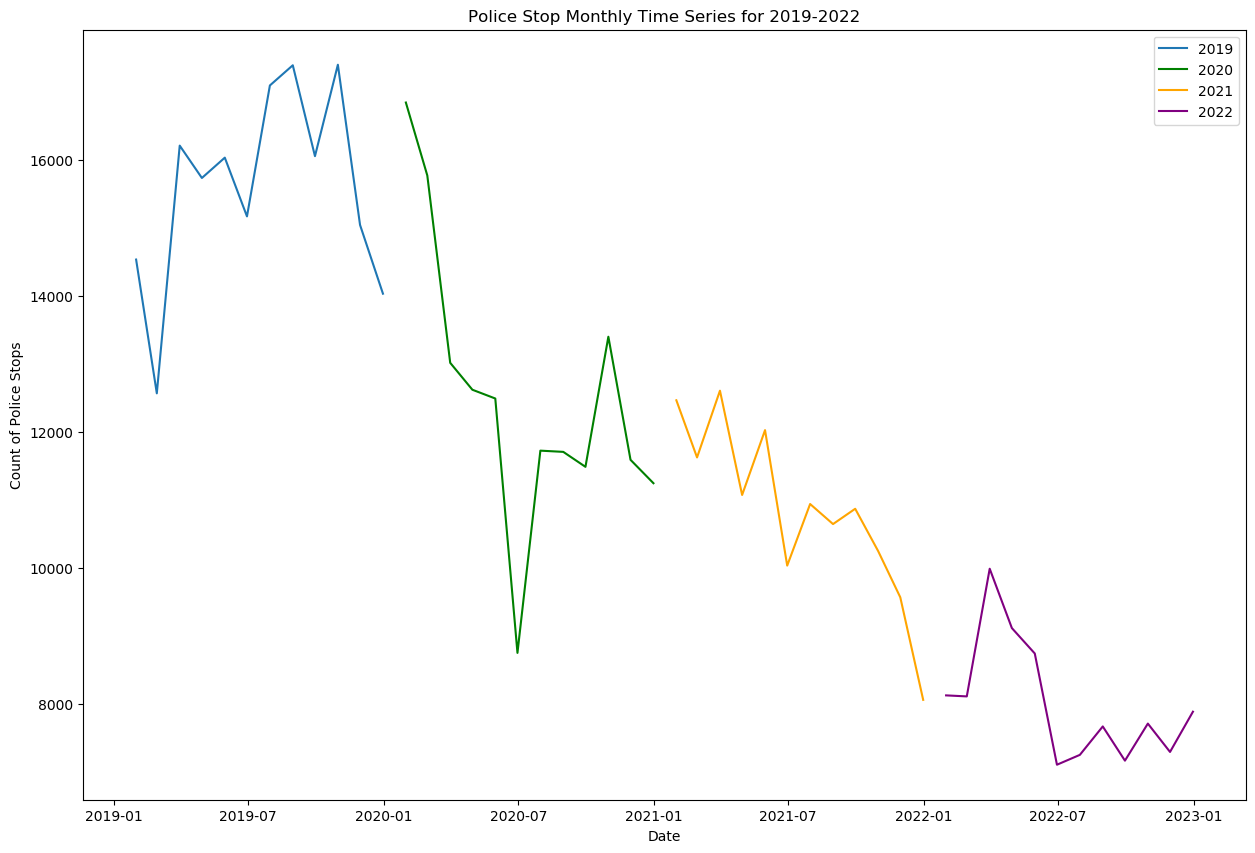

In [84]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


plt.plot(ripa_stops_ts['2019'])
plt.plot(ripa_stops_ts['2020'], color='green')
plt.plot(ripa_stops_ts['2021'], color='orange')
plt.plot(ripa_stops_ts['2022'], color='purple')
plt.title("Police Stop Monthly Time Series for 2019-2022")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.legend(['2019', '2020', '2021', '2022'])
plt.show()

# Time Series: Trend, Seasonality, and Residuals

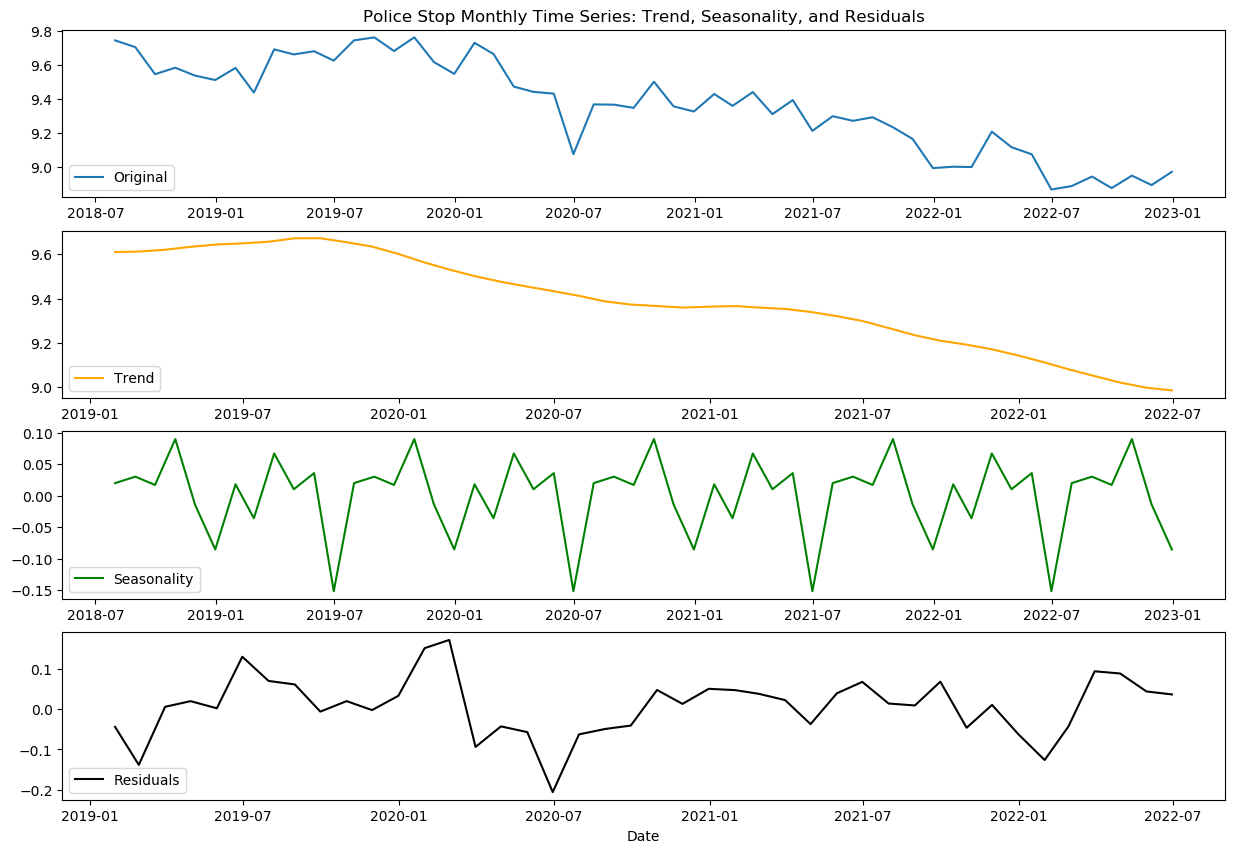

In [85]:
ripa_stops_log = np.log(ripa_stops_ts)

decom_ripa = seasonal_decompose(ripa_stops_log)

trend_ripa_stops = decom_ripa.trend
season_ripa_stops = decom_ripa.seasonal
resid_ripa_stops = decom_ripa.resid

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


plt.xlabel("Date")
plt.subplot(411)
plt.plot(ripa_stops_log)
plt.title("Police Stop Monthly Time Series: Trend, Seasonality, and Residuals")
plt.legend(["Original"], loc = "lower left")
plt.subplot(412)
plt.plot(trend_ripa_stops, color='orange')
plt.legend(["Trend"], loc = "lower left")
plt.subplot(413)
plt.plot(season_ripa_stops, color='green')
plt.legend(["Seasonality"], loc = "lower left")
plt.subplot(414)
plt.plot(resid_ripa_stops, color='black')
plt.legend(["Residuals"], loc = "lower left")
plt.xlabel("Date")
plt.show()



## Removing Trend and Seasonality

In [86]:

diff_ripa = ripa_stops_log - ripa_stops_log.shift()
diff_ripa.dropna(inplace = True)



In [87]:
%store diff_ripa

Stored 'diff_ripa' (Series)


In [95]:
%store ripa_stops_log 
%store decom_ripa 
%store trend_ripa_stops 
%store season_ripa_stops 
%store resid_ripa_stops 





Stored 'ripa_stops_log' (Series)
Stored 'decom_ripa' (DecomposeResult)
Stored 'trend_ripa_stops' (Series)
Stored 'season_ripa_stops' (Series)
Stored 'resid_ripa_stops' (Series)
